In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD,
  TERMS_OF_PAYMENT_KEY  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df.query('ENTERPRISE_ACCOUNT_NO == "7100007382"').CREDIT_CONTROL_AREA.unique()

array(['PD', 'PRMD'], dtype=object)

In [7]:
df.ENTERPRISE_ACCOUNT_NO.value_counts()

7100007382    12071520
               9370453
7100017882     3147195
7100002977     3010252
7100000361     1378249
                ...   
7100008760           1
7100021436           1
7100015669           1
7100005267           1
7100009415           1
Name: ENTERPRISE_ACCOUNT_NO, Length: 7708, dtype: int64

In [8]:
# df['PAYMENT_DATE']=pd.to_datetime(df['PAYMENT_DATE'])
# df.query('"2024-01-01" >=PAYMENT_DATE')

In [9]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df['CC_DAYS_TO_ADD']=df['CC_DAYS_TO_ADD'].apply(lambda x: float(x))
df['AMOUNT_IN_LOCAL_CURRENCY']=df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
df.reset_index(inplace = True)


In [10]:
def calc_WAPD(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [11]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df.reset_index(inplace = True)
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [12]:
# Returns a tuple of DataFrames sorted by DSO term

def get_terms(ENTERPRISE_ACCOUNT_NO):
    return_list = []
    
    terms_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    
    # terms_df.reset_index(inplace = True)
    terms_list = terms_df['CC_DAYS_TO_ADD'].unique()
    print(terms_list)
    
    for dso_term in terms_list:
        name = str(dso_term)+"_term"
        name = terms_df.query('CC_DAYS_TO_ADD ==@dso_term')
        return_list.append(name)
    
    return return_list
 
# EAN = "7100000391"
# s = get_terms(EAN)

In [13]:
def search_EAN(CUSTOMER_df):
    # CUSTOMER_df=EN_df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
   
    # CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    
    
    
    return CUSTOMER_df

In [14]:
def search_EAN_terms(ENTERPRISE_ACCOUNT_NO):
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
    
#     loop for terms 

    four = CUSTOMER_df.query('CC_DAYS_TO_ADD ==4.000000000')
    thirty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==30.000000000')
    sixty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==60.000000000')
    ninty = CUSTOMER_df.query('CC_DAYS_TO_ADD ==90.000000000')

# FOUR



    four['AMOUNT_IN_LOCAL_CURRENCY']=four['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    four['Sub Payment Date from Invoice Date']=(four['PAYMENT_DATE']-four['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    four['Weighted Invoice Value']= four['Sub Payment Date from Invoice Date']*four['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(four['PAYMENT_DATE'])
    four['90_days_ago']= current - pd.to_timedelta('90 days')
    four = calc_WAPD(four)
    
#   THIRTY  
    
    thirty['AMOUNT_IN_LOCAL_CURRENCY']=thirty['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    thirty['Sub Payment Date from Invoice Date']=(thirty['PAYMENT_DATE']-thirty['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    thirty['Weighted Invoice Value']= thirty['Sub Payment Date from Invoice Date']*thirty['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(thirty['PAYMENT_DATE'])
    thirty['90_days_ago']= current - pd.to_timedelta('90 days')
    thirty = calc_WAPD(thirty)
    
    
    
    
    return CUSTOMER_df

# **********************************************************************************************************

# Visualization

## Customer

In [15]:
customer = "2057194397"
t = search_customer(customer)

In [16]:
t.tail()

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY,WAPD,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago
573,42206977,50132831,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-21,ZF,01 - Invoice,620.3200,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,32,19850.2400,2023-06-24
574,42210703,50137166,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-22,ZF,01 - Invoice,992.0000,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,31,30752.0000,2023-06-24
575,42213053,50139929,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-24,ZF,01 - Invoice,3232.3800,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,29,93739.0200,2023-06-24
576,42215629,50142968,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-25,ZF,01 - Invoice,4801.2900,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,28,134436.1200,2023-06-24
577,42220857,50149097,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-25,ZF,01 - Invoice,608.5000,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,28,17038.0000,2023-06-24


In [17]:
t['month'] = t['PAYMENT_DATE'].dt.strftime('%b')

In [18]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

dfp1 = pd.pivot_table(data=t, index=[t.PAYMENT_DATE.dt.year,t.CREDIT_CONTROL_AREA], columns='month', values='WAPD')
dfp1 = dfp1.reindex(year_order, axis=1)
dfp1

,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,CREDIT_CONTROL_AREA,,,,,,,,,,,,
2022,PD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9744,29.9637,29.9682,30.0434
2023,PD,29.7159,28.5953,25.1921,24.8993,24.3104,25.7423,25.0257,26.6483,27.9685,NaN,NaN,NaN


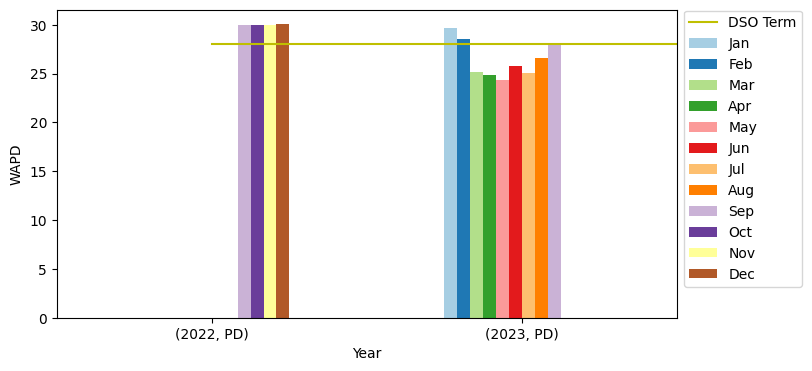

In [19]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

In [20]:
EAN = "7100007382"
s = get_terms(EAN)
# DSO terms are printed below

[ 15.  65.  60.  75.  90.  30.  32.  29.  31.   7.  35.  26.  59.  61.
  33. 120.   0.  34.  40.  27.  28.  37.  39.  36.  10.  38.   8.   5.]


In [21]:
s[5].CREDIT_CONTROL_AREA.unique()

array(['PD', 'PRMD'], dtype=object)

In [22]:
fi=search_EAN(s[5])

In [138]:
fi.head()

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY,WAPD,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago,month
0,1386410,3146136,2057201008,7100007382,7100007382 - CVS,0000036098,2057201008,2022-08-04,ZF,01 - Invoice,1007.0800,PD,CLEAR,2022-08-29,30.0000,Y030,23.8677,25,25177.0000,2022-05-31,Aug
1,1738581,3569284,2057201008,7100007382,7100007382 - CVS,0000036098,2057201008,2022-08-11,ZF,01 - Invoice,682.0600,PD,CLEAR,2022-09-02,30.0000,Y030,25.4026,22,15005.3200,2022-06-04,Sep
2,1744826,3576187,2057201008,7100007382,7100007382 - CVS,0000036098,2057201008,2022-08-11,ZF,01 - Invoice,273.6000,PD,CLEAR,2022-09-02,30.0000,Y030,25.4026,22,6019.2000,2022-06-04,Sep
3,1785562,3621447,2057201008,7100007382,7100007382 - CVS,0000036098,2057201008,2022-08-11,ZF,01 - Invoice,1025.8100,PD,CLEAR,2022-09-02,30.0000,Y030,25.4026,22,22567.8200,2022-06-04,Sep
4,3360579,5435864,2057201008,7100007382,7100007382 - CVS,0000036098,2057201008,2022-08-25,ZF,01 - Invoice,466.5600,PD,CLEAR,2022-09-19,30.0000,Y030,25.4366,25,11664.0000,2022-06-21,Sep


In [23]:
fi['month'] = fi['PAYMENT_DATE'].dt.strftime('%b')

In [143]:
df_final = pd.DataFrame({'Year': fi.PAYMENT_DATE.dt.year,
                   'Month': fi.month,
                   'CREDIT_CONTROL_AREA': fi.CREDIT_CONTROL_AREA,
                   'WAPD':fi.WAPD,
                    "CC_DAYS_TO_ADD":fi.CC_DAYS_TO_ADD})

In [144]:
monthly = df_final.groupby(['Year','CREDIT_CONTROL_AREA','Month'])['WAPD'].mean()
# year_order = ['Jan','Feb',||year_order, axis=1)

In [150]:
exp_cash_flow_grp = (
    df_final
    .filter(["Year", "Month","CREDIT_CONTROL_AREA","WAPD","CC_DAYS_TO_ADD"])
    # .query('DOCUMENT_TYPE in ("DH", "DL", "DZ", "DW", "DC")')
    .groupby(['Year','Month','CREDIT_CONTROL_AREA',"CC_DAYS_TO_ADD"])
    .agg({'WAPD' : ['mean']})
    .sort_values(['Year',"Month","CC_DAYS_TO_ADD"])
    .reset_index()
)
exp_cash_flow_grp.columns = ['Year','Month', 'CREDIT_CONTROL_AREA','CC_DAYS_TO_ADD',"WAPD"]

In [153]:
exp_cash_flow_grp["period"] =exp_cash_flow_grp["Month"] +"\n"+  exp_cash_flow_grp["Year"].astype(str)
exp_cash_flow_grp

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD,period
0,2022,Aug,PD,30.0000,23.8677,Aug\n2022
1,2022,Dec,PD,30.0000,26.6555,Dec\n2022
2,2022,Nov,PD,30.0000,26.6903,Nov\n2022
3,2022,Nov,PRMD,30.0000,26.7108,Nov\n2022
4,2022,Oct,PD,30.0000,26.7181,Oct\n2022
5,2022,Sep,PD,30.0000,25.4173,Sep\n2022
6,2023,Apr,PD,30.0000,24.9739,Apr\n2023
7,2023,Aug,PD,30.0000,26.6327,Aug\n2023
8,2023,Feb,PD,30.0000,25.5713,Feb\n2023
9,2023,Jan,PD,30.0000,25.4317,Jan\n2023


In [154]:
df=exp_cash_flow_grp
df.period.unique()

array(['Aug\n2022', 'Dec\n2022', 'Nov\n2022', 'Oct\n2022', 'Sep\n2022',
       'Apr\n2023', 'Aug\n2023', 'Feb\n2023', 'Jan\n2023', 'Jul\n2023',
       'Jun\n2023', 'Mar\n2023', 'May\n2023', 'Sep\n2023'], dtype=object)

In [46]:
import matplotlib.transforms as transforms

In [48]:
# num_fruit = len(fruits)
fruits = ['Aug\n2022', 'Dec\n2022', 'Nov\n2022', 'Oct\n2022', 'Sep\n2022',
       'Apr\n2023', 'Aug\n2023', 'Feb\n2023', 'Jan\n2023', 'Jul\n2023',
       'Jun\n2023', 'Mar\n2023', 'May\n2023', 'Sep\n2023']
years= ['PD', 'PRMD']
num_fruit = len(fruits)
num_years = len(years)
# num_CCA= len(CCA)

    Year Month CREDIT_CONTROL_AREA    WAPD     period
0   2022   Aug                  PD 23.8677  Aug\n2022
1   2022   Dec                  PD 26.6555  Dec\n2022
2   2022   Nov                  PD 26.6903  Nov\n2022
3   2022   Nov                PRMD 26.7108  Nov\n2022
4   2022   Oct                  PD 26.7181  Oct\n2022
5   2022   Sep                  PD 25.4173  Sep\n2022
6   2023   Apr                  PD 24.9739  Apr\n2023
7   2023   Aug                  PD 26.6327  Aug\n2023
8   2023   Feb                  PD 25.5713  Feb\n2023
9   2023   Jan                  PD 25.4317  Jan\n2023
10  2023   Jul                  PD 25.7413  Jul\n2023
11  2023   Jun                  PD 25.2676  Jun\n2023
12  2023   Mar                  PD 25.3288  Mar\n2023
13  2023   May                  PD 24.6029  May\n2023
14  2023   Sep                  PD 27.1369  Sep\n2023


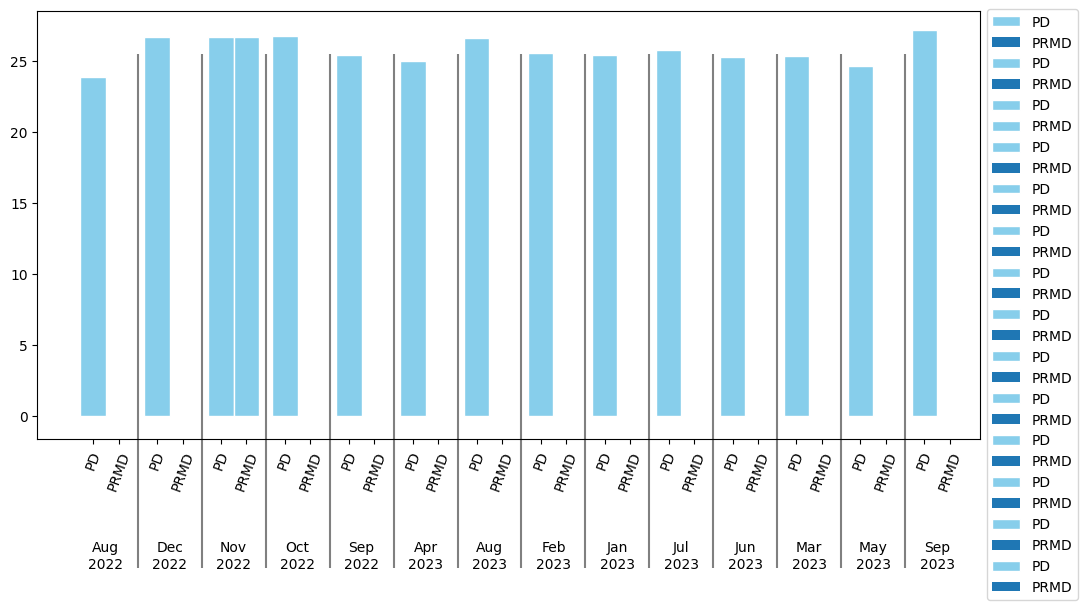

In [69]:
width = 0.8
fig, ax = plt.subplots(figsize=(10, 6))
for i, fruit in enumerate(fruits):
    # print(fruit) YEAR
    for j, year in enumerate(years):
        # print(year) MONTH
        
        plt.bar(
            i + width / num_years * (j - (num_years - 1) / 2), 
                df[(df['period'] == fruit) & (df['CREDIT_CONTROL_AREA'] == year)]['WAPD'],
                width / num_years, color='skyblue', ec='white',label=year
               )
        
plt.xticks([
        i + width / num_years * (j - (num_years - 1) /2) 
            for i in range(num_fruit) for j in range(num_years)
    ],
           np.tile(years, num_fruit), rotation=70)
    

ax = plt.gca()
# ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax.grid(True, axis='y')
# ax.autoscale(False, axis='y')
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
# plt.plot(fi.CC_DAYS_TO_ADD)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.3, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, .9, -0.3, color='gray', clip_on=False, transform=trans)
plt.tight_layout()
_ = plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
print(df)
# figure(figsize=(8, 6), dpi=80)
plt.show()

In [155]:
df.head(1)

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD,period
0,2022,Aug,PD,30.0000,23.8677,Aug\n2022


In [81]:
dfp1 = pd.pivot_table(data=df, index=[df.Year,df.Month,], columns='CREDIT_CONTROL_AREA', values='WAPD')
# dfp1 = dfp1.reindex(year_order, axis=1)
dfp1

CREDIT_CONTROL_AREA      PD    PRMD
Year Month                         
2022 Aug            23.8677     NaN
     Dec            26.6555     NaN
     Nov            26.6903 26.7108
     Oct            26.7181     NaN
     Sep            25.4173     NaN
2023 Apr            24.9739     NaN
     Aug            26.6327     NaN
     Feb            25.5713     NaN
     Jan            25.4317     NaN
     Jul            25.7413     NaN
     Jun            25.2676     NaN
     Mar            25.3288     NaN
     May            24.6029     NaN
     Sep            27.1369     NaN

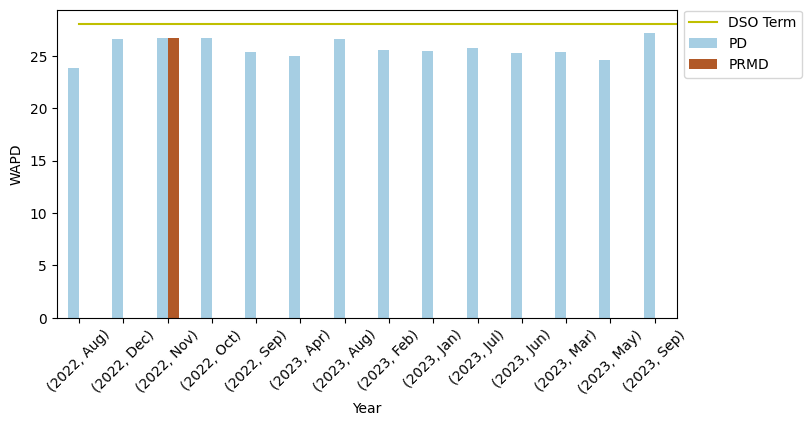

In [83]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=45,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=45,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
for i, fruit in enumerate(fruits):
    ax.text(i, -0.2, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, 0, -0.3, color='lightgrey', clip_on=False, transform=trans)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [156]:
df.head()

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD,period
0,2022,Aug,PD,30.0000,23.8677,Aug\n2022
1,2022,Dec,PD,30.0000,26.6555,Dec\n2022
2,2022,Nov,PD,30.0000,26.6903,Nov\n2022
3,2022,Nov,PRMD,30.0000,26.7108,Nov\n2022
4,2022,Oct,PD,30.0000,26.7181,Oct\n2022


In [202]:
dff

,year,month,CCA,WAPD,dso_term
0,2022,Aug,PD,23.8677,30.0000
1,2022,Dec,PD,26.6555,30.0000
2,2022,Nov,PD,26.6903,30.0000
3,2022,Nov,PRMD,26.7108,30.0000
4,2022,Oct,PD,26.7181,30.0000
5,2022,Sep,PD,25.4173,30.0000
6,2023,Apr,PD,24.9739,30.0000
7,2023,Aug,PD,26.6327,30.0000
8,2023,Feb,PD,25.5713,30.0000
9,2023,Jan,PD,25.4317,30.0000


In [160]:
dff = pd.DataFrame(
    dict(
        year=df.Year.values ,
        month=df.Month.values,
        CCA= df.CREDIT_CONTROL_AREA.values,
        WAPD=df.WAPD.values,
        dso_term = df.CC_DAYS_TO_ADD.values
    )
)

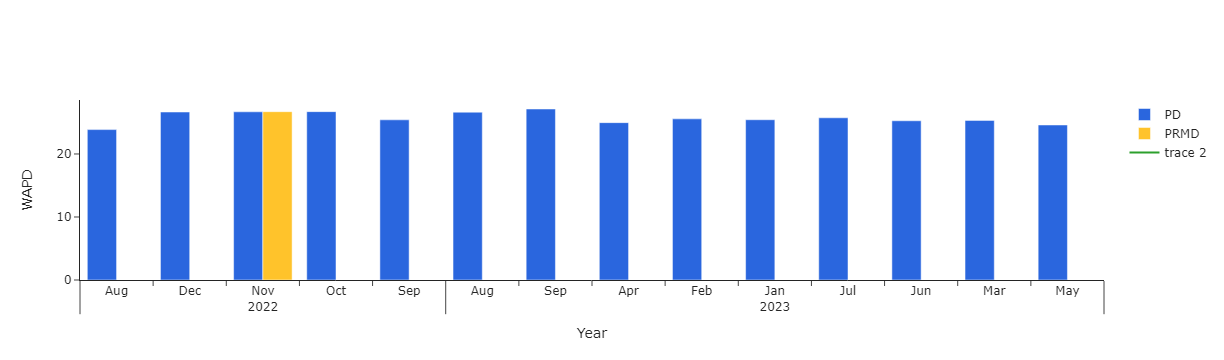

In [186]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# fig = go.Figure()
fig = make_subplots(1,1)

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Year"),
    yaxis=dict(title_text="WAPD"),
    barmode="group",
)

colors = ["#2A66DE", "#FFC32B"]
# fig.add_trace(go.Scatter(x=dff['month'], y=dff['CCA'], line=dict(color='red'), name='DSO term'),
#               row = 1, col = 1)

for r, c in zip(dff.CCA.unique(), colors):
    plot_df = dff[dff.CCA == r]
    fig.add_trace(go.Bar(x=[plot_df.year, plot_df.month], y=plot_df.WAPD, name=r, marker_color=c),
              row = 1, col = 1)
# fig.add_hline(y=30.00,name = "DSO Term")

    
fig.add_traces(go.Scatter(x= plot_df.month, y=plot_df.CCA, mode = 'lines'))


# fig.plot(fi.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
fig.show()

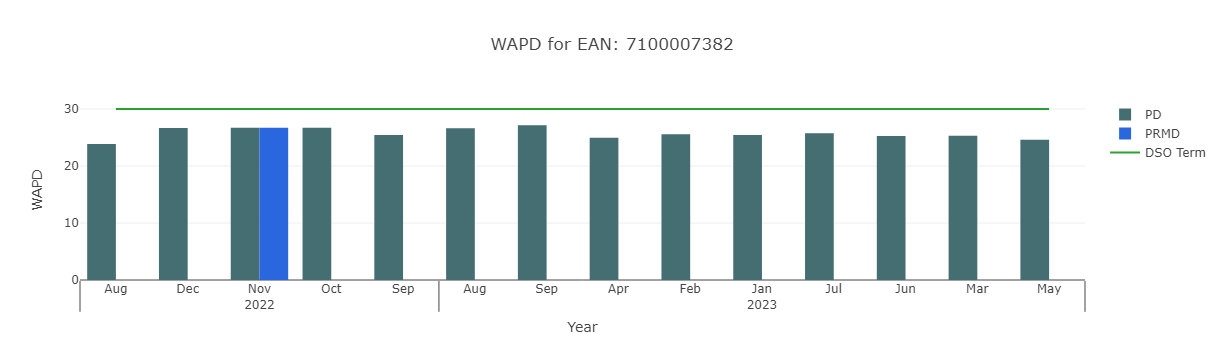

In [217]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
# fig = make_subplots(1,1)

fig.update_layout(
    template="none",
    xaxis=dict(title_text="Year"),
    yaxis=dict(title_text="WAPD"),
    barmode="group",
)

colors = ["#456e73","#2A66DE", "#FFC32B","#457353"]

for r, c in zip(dff.CCA.unique(), colors):
    plot_df = dff[dff.CCA == r]
    fig.add_trace(go.Bar(x=[plot_df.year, plot_df.month], y=plot_df.WAPD, name=r, marker_color=c))

    
fig.add_trace(go.Scatter(x= [dff.year, dff.month], y=dff.dso_term, mode = 'lines',name = "DSO Term"))


# fig.plot(fi.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
fig.update_layout(title='WAPD for EAN: '+EAN)
fig.show()

In [210]:
dff

,year,month,CCA,WAPD,dso_term
0,2022,Aug,PD,23.8677,30.0000
1,2022,Dec,PD,26.6555,30.0000
2,2022,Nov,PD,26.6903,30.0000
3,2022,Nov,PRMD,26.7108,30.0000
4,2022,Oct,PD,26.7181,30.0000
5,2022,Sep,PD,25.4173,30.0000
6,2023,Apr,PD,24.9739,30.0000
7,2023,Aug,PD,26.6327,30.0000
8,2023,Feb,PD,25.5713,30.0000
9,2023,Jan,PD,25.4317,30.0000


In [ ]:
width = 0.8
for i, fruit in enumerate(fruits):
    # print(fruit) YEAR
    for j, year in enumerate(years):
        # print(year) MONTH
        plt.bar(i + width / num_years * (j - (num_years - 1) / 2),
                df[(df['Year'] == fruit) & (df['Month'] == year)]['WAPD'],
                width / num_years, color='skyblue', ec='white')
plt.xticks([i + width / num_years * (j - (num_years - 1) / 2) 
            for i in range(num_fruit) for j in range(num_years)],
           np.tile(years, num_fruit), rotation=45)
# plt.figure(figsize=(300,6))
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(True, axis='y')
ax.autoscale(False, axis='y')
trans = blended_transform_factory(ax.transData, ax.transAxes)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.2, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, 0, -0.3, color='lightgrey', clip_on=False, transform=trans)
plt.tight_layout()
# print(df)
# figure(figsize=(8, 6), dpi=80)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns

fruits = ['apples', 'pears', 'nectarines', 'plums', 'grapes', 'strawberries']
years = [2015, 2016, 2017]
num_fruit = len(fruits)
num_years = len(years)
df = pd.DataFrame({'fruit': np.tile(fruits, num_years),
                   'year': np.repeat(years, num_fruit),
                   'value': np.random.randint(1, 8, num_fruit * num_years)})

width = 0.8
for i, fruit in enumerate(fruits):
    for j, year in enumerate(years):
        plt.bar(i + width / num_years * (j - (num_years - 1) / 2),
                df[(df['fruit'] == fruit) & (df['year'] == year)]['value'],
                width / num_years, color='skyblue', ec='white')
plt.xticks([i + width / num_years * (j - (num_years - 1) / 2) for i in range(num_fruit) for j in range(num_years)],
           np.tile(years, num_fruit), rotation=45)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(True, axis='y')
ax.autoscale(False, axis='y')
trans = blended_transform_factory(ax.transData, ax.transAxes)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.2, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, 0, -0.3, color='lightgrey', clip_on=False, transform=trans)
plt.tight_layout()
print(df)
plt.show()

In [ ]:
four=search_EAN(s[0])
thirty=search_EAN(s[1])
ninty=search_EAN(s[2])
sixty=search_EAN(s[3])



In [ ]:
four.CREDIT_CONTROL_AREA.unique()

In [ ]:
sixty

In [ ]:
four['month'] = four['PAYMENT_DATE'].dt.strftime('%b')
thirty['month'] = thirty['PAYMENT_DATE'].dt.strftime('%b')
sixty['month'] = sixty['PAYMENT_DATE'].dt.strftime('%b')
ninty['month'] = ninty['PAYMENT_DATE'].dt.strftime('%b')

In [ ]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_4 = pd.pivot_table(data=four, index=[four.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_4 = dfp_4.reindex(year_order, axis=1)
dfp_4

In [ ]:
four.query('month == "Sep"')[['AMOUNT_IN_LOCAL_CURRENCY','WAPD']].describe()

In [ ]:
dfp_4.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired',zorder=0)
plt.plot(four.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
_ = plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_30 = pd.pivot_table(data=thirty, index=[thirty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_30 = dfp_30.reindex(year_order, axis=1)
dfp_30

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_60 = pd.pivot_table(data=sixty, index=[sixty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_60 = dfp_60.reindex(year_order, axis=1)
dfp_60

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_90 = pd.pivot_table(data=ninty, index=[ninty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_90 = dfp_90.reindex(year_order, axis=1)
dfp_90

In [ ]:
ax30 = dfp_30.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax30.plot(thirty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax30.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
ax60 = dfp_60.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax60.plot(sixty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax60.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
sixty.CC_DAYS_TO_ADD

In [ ]:
ax90 = dfp_90.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax90.plot(ninty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax90.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
 from pivottablejs import pivot_ui

In [ ]:
dfp_4

In [ ]:
pivot_ui(dfp_4)

## National Account